In [ ]:
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/Stress-Lysis.csv")

In [ ]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head())
    print("##################### Tail #####################")
    print(dataframe.tail())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(2001, 4)
##################### Types #####################
Humidity        float64
Temperature     float64
Step count        int64
Stress Level      int64
dtype: object
##################### Head #####################
   Humidity  Temperature  Step count  Stress Level
0     21.33        90.33         123             1
1     21.41        90.41          93             1
2     27.12        96.12         196             2
3     27.64        96.64         177             2
4     10.87        79.87          87             0
##################### Tail #####################
      Humidity  Temperature  Step count  Stress Level
1996     21.82        90.82          96             1
1997     10.45        79.45          45             0
1998     27.22        96.22         135             2
1999     12.46        81.46          64             0
2000     16.87        85.87          50             1
##################### NA #####################
Humid

Veriye İlk Bakış:

1. 4 değişkenimiz ve 2001 değerimiz vardır.
2. Boş değerimiz yoktur.
3. Aykırı değer yok gibi gözüküyor.


In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                 dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                 dataframe[col].dtypes == "O"]

  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" ]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols,num_but_cat

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 2001
Variables: 4
cat_cols: 1
num_cols: 3
cat_but_car: 0
num_but_cat: 1


In [ ]:
print(cat_cols)
print(num_cols)

['Stress Level']
['Humidity', 'Temperature', 'Step count']


In [ ]:
df["Stress Level"].value_counts()

,count
Stress Level,
1,790
2,710
0,501


count    2001.000000
mean       20.000000
std         5.777833
min        10.000000
5%         11.000000
10%        12.000000
20%        14.000000
30%        16.000000
40%        18.000000
50%        20.000000
60%        22.000000
70%        24.000000
80%        26.000000
90%        28.000000
95%        29.000000
99%        29.800000
max        30.000000
Name: Humidity, dtype: float64


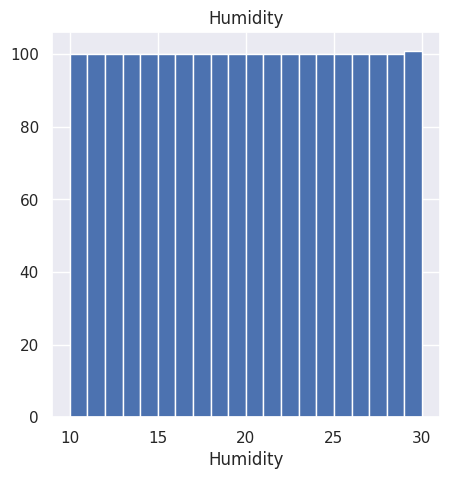

count    2001.000000
mean       89.000000
std         5.777833
min        79.000000
5%         80.000000
10%        81.000000
20%        83.000000
30%        85.000000
40%        87.000000
50%        89.000000
60%        91.000000
70%        93.000000
80%        95.000000
90%        97.000000
95%        98.000000
99%        98.800000
max        99.000000
Name: Temperature, dtype: float64


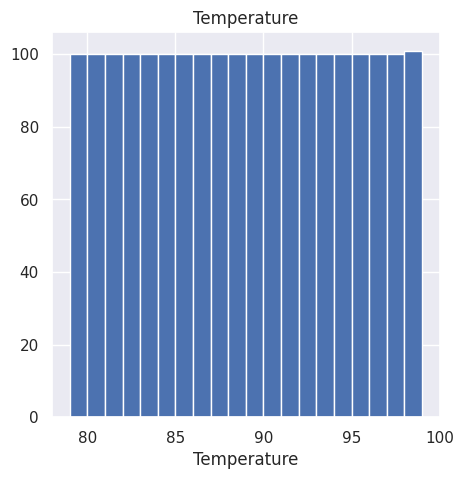

count    2001.000000
mean      100.141429
std        58.182948
min         0.000000
5%         10.000000
10%        20.000000
20%        40.000000
30%        60.000000
40%        80.000000
50%       101.000000
60%       121.000000
70%       140.000000
80%       160.000000
90%       180.000000
95%       190.000000
99%       198.000000
max       200.000000
Name: Step count, dtype: float64


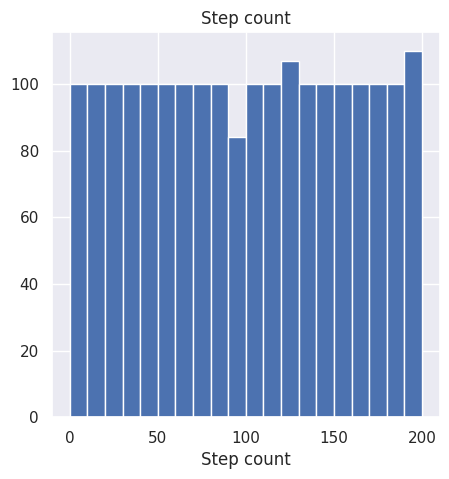

In [ ]:
#Numerik değişken analizi
def num_summary(dataframe, numerical_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)
  if plot:
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.title(numerical_col)
    plt.show(block=True)

for col in num_cols:
  num_summary(df, col, plot=True)

In [ ]:
#Kategorik değişkenim sadece hedef değişken olduğu için bakmıyorum.
#Hedef değişkenin numerik değişkenlere göre analizi.
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Stress Level", col)

              Humidity
Stress Level          
0               12.500
1               18.955
2               26.455


              Temperature
Stress Level             
0                  81.500
1                  87.955
2                  95.455


              Step count
Stress Level            
0              42.934132
1              78.130380
2             165.000000




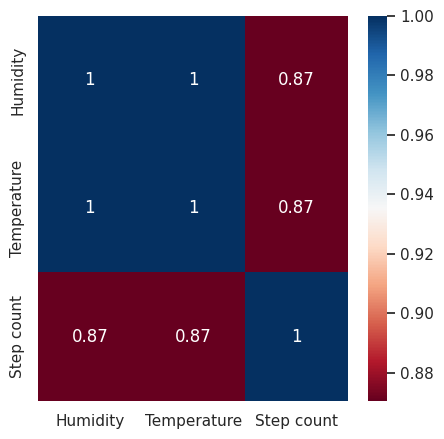

In [ ]:
#Korelasyon analizi
corr = df[num_cols].corr()

sns.set(rc={'figure.figsize': (5,5)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

In [ ]:
#Aykırı değer analizi
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5*interquantile_range
  low_limit = quartile1 - 1.5*interquantile_range
  return low_limit, up_limit

def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

for col in num_cols:
    print(col, check_outlier(df, col))

Humidity False
Temperature False
Step count False


Herhangi bir aykırı değerimiz yoktur. Devam ediyoruz...

In [ ]:
#Standartlaştırma yapıyoruz.
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head(10)

,Humidity,Temperature,Step count,Stress Level
0,0.230248,0.230248,0.392972,1
1,0.244097,0.244097,-0.122772,1
2,1.232604,1.232604,1.647949,2
3,1.322626,1.322626,1.321311,2
4,-1.580572,-1.580572,-0.225920,0
5,-1.504400,-1.504400,-1.033919,0
6,-0.318538,-0.318538,-0.208729,1
7,1.419572,1.419572,1.063439,2
8,-0.995432,-0.995432,-0.672898,0
9,1.061217,1.061217,1.166588,2


In [ ]:
dff = df.copy()

In [ ]:
y = dff["Stress Level"]
X = dff.drop("Stress Level", axis=1)


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.20, random_state=42)

models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ('Adaboost', AdaBoostClassifier()),
          ("XGBoost", XGBClassifier(objective='reg:squarederror')),
          ("CatBoost", CatBoostClassifier(verbose=False))]

for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        msg = "%s: (%f)" % (name, accuracy)
        print(msg)

LR: (1.000000)
KNN: (1.000000)
CART: (1.000000)
RF: (1.000000)
GBM: (1.000000)
Adaboost: (1.000000)
XGBoost: (1.000000)
CatBoost: (1.000000)


In [ ]:
y = df["Stress Level"]
X = df.drop(["Stress Level"], axis = 1)

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.20, random_state=42)

LR_model = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
y_prob = LR_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       160
           2       1.00      1.00      1.00       146

    accuracy                           1.00       401
   macro avg       1.00      1.00      1.00       401
weighted avg       1.00      1.00      1.00       401



Test verilerinden rastgele birisini alıp bu modeli test ediyoruz.

In [ ]:
random_user  =X.sample(10)
random_user

,Humidity,Temperature,Step count
1102,-1.151238,-1.151238,-0.655707
414,0.261409,0.261409,0.049143
338,-0.446646,-0.446646,-1.480897
1203,-0.081366,-0.081366,-0.088389
260,-0.074441,-0.074441,-0.019623
1415,1.635970,1.635970,0.771184
1012,-0.100409,-0.100409,0.375781
1330,0.950421,0.950421,1.286928
513,1.397067,1.397067,0.839950
1271,1.575379,1.575379,1.390077


In [ ]:
LR_model.predict(random_user)

array([0, 1, 1, 1, 1, 2, 1, 2, 2, 2])

2. model testi için kullanıyoruz(opsiyonel)

In [ ]:
y_pred = LR_model.predict(X)

In [ ]:
y_pred[0:10]

array([1, 1, 2, 2, 0, 0, 1, 2, 0, 2])

In [ ]:
y[0:10]

,Stress Level
0,1
1,1
2,2
3,2
4,0
5,0
6,1
7,2
8,0
9,2
